# Proj03_KNN_DetectingRockOrMine

Credits:

- [2021 Python for Machine Learning & Data Science Masterclass by Jose Portilla Udemy](https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/)

## The Sonar Data 

### Detecting a Rock or a Mine

Sonar (sound navigation ranging) is a technique that uses sound propagation (usually underwater, as in submarine navigation) to navigate, communicate with or detect objects on or under the surface of the water, such as other vessels.

<img src="images/sonar.jpg"  width="200px" align="center">

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 

<img src="images/mine.jpg"  width="200px" align="center">

Our main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


[Data Source](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [40]:
df = pd.read_csv('data/sonar.all-data.csv')
df.sample(5)

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
18,0.0270,0.0092,0.0145,0.0278,0.0412,0.0757,0.1026,0.1138,0.0794,0.1520,...,0.0084,0.0010,0.0018,0.0068,0.0039,0.0120,0.0132,0.0070,0.0088,R
182,0.0095,0.0308,0.0539,0.0411,0.0613,0.1039,0.1016,0.1394,0.2592,0.3745,...,0.0181,0.0019,0.0102,0.0133,0.0040,0.0042,0.0030,0.0031,0.0033,M
102,0.0587,0.1210,0.1268,0.1498,0.1436,0.0561,0.0832,0.0672,0.1372,0.2352,...,0.0331,0.0111,0.0088,0.0158,0.0122,0.0038,0.0101,0.0228,0.0124,M
66,0.0265,0.0440,0.0137,0.0084,0.0305,0.0438,0.0341,0.0780,0.0844,0.0779,...,0.0038,0.0187,0.0156,0.0068,0.0097,0.0073,0.0081,0.0086,0.0095,R
147,0.0654,0.0649,0.0737,0.1132,0.2482,0.1257,0.1797,0.0989,0.2460,0.3422,...,0.0210,0.0361,0.0239,0.0447,0.0394,0.0355,0.0440,0.0243,0.0098,M


## EDA

In [41]:
df.isnull().sum().sum()

0

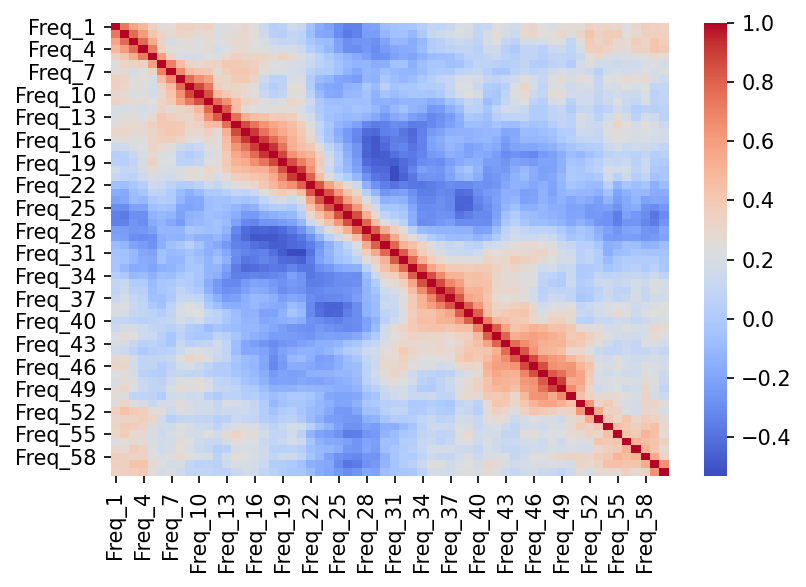

In [42]:
plt.figure(figsize=(6,4),dpi=150)
sns.heatmap(df.corr(),cmap='coolwarm');

- The frequencies are correlated to the nearby frequencies in the order they are sampled.

### Top 5 correlated (absolute) frequencies with the target label


In [43]:
# Perform one-hot enconding simply using map
df['Target'] = df["Label"].map({'R':0, 'M':1})
df.sample(5)

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label,Target
154,0.0117,0.0069,0.0279,0.0583,0.0915,0.1267,0.1577,0.1927,0.2361,0.2169,...,0.0029,0.0020,0.0013,0.0029,0.0020,0.0062,0.0026,0.0052,M,1
145,0.0721,0.1574,0.1112,0.1085,0.0666,0.1800,0.1108,0.2794,0.1408,0.0795,...,0.0127,0.0082,0.0281,0.0117,0.0092,0.0147,0.0157,0.0129,M,1
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M,1
57,0.0216,0.0124,0.0174,0.0152,0.0608,0.1026,0.1139,0.0877,0.1160,0.0866,...,0.0049,0.0096,0.0134,0.0122,0.0047,0.0018,0.0006,0.0023,R,0
90,0.0126,0.0519,0.0621,0.0518,0.1072,0.2587,0.2304,0.2067,0.3416,0.4284,...,0.0048,0.0199,0.0126,0.0022,0.0037,0.0034,0.0114,0.0077,R,0


In [45]:
df.corr()['Target'].abs().sort_values(ascending=False)[:6]

Target     1.000000
Freq_11    0.432855
Freq_12    0.392245
Freq_49    0.351312
Freq_10    0.341142
Freq_45    0.339406
Name: Target, dtype: float64

## KNN

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X = df.drop(['Label','Target'], axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.1, random_state=42)

scalar = StandardScaler()
knn = KNeighborsClassifier()

operations = [('scalar',scalar),('knn',knn)]
pipe = Pipeline(operations)

k_values = list(range(1,20))
param_grid = {'knn__n_neighbors':k_values}
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,
                                  scoring='accuracy')
full_cv_classifier.fit(X_train,y_train)

full_pred = full_cv_classifier.predict(X_test)
print(classification_report(y_test,full_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



In [48]:
full_cv_classifier.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

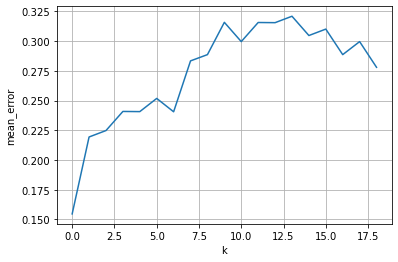

In [55]:
(1-pd.DataFrame(full_cv_classifier.cv_results_)['mean_test_score']).plot();
plt.xlabel('k')
plt.ylabel('mean_error')
plt.grid()

- The elbow plot also suggests that the best k value is 1!

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,full_pred)

array([[12,  1],
       [ 1,  7]])

- Although we have a goo accuracy, we still have a false negative (there is a rock but we classified it as an explosive mine)! 